In [1]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry
using Images

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [2]:
master_view = [1000:1500,5900:6500]

2-element Array{UnitRange{Int64},1}:
 1000:1500
 5900:6500

In [3]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

In [4]:
meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [5]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [6]:
# compile 
slave_data, flat, lut = coregister_slave(master_view, slave_data_path, meta, precise_orbit, dem);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [7]:
master_data = Load.slc_data(master_data_path, master_view);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


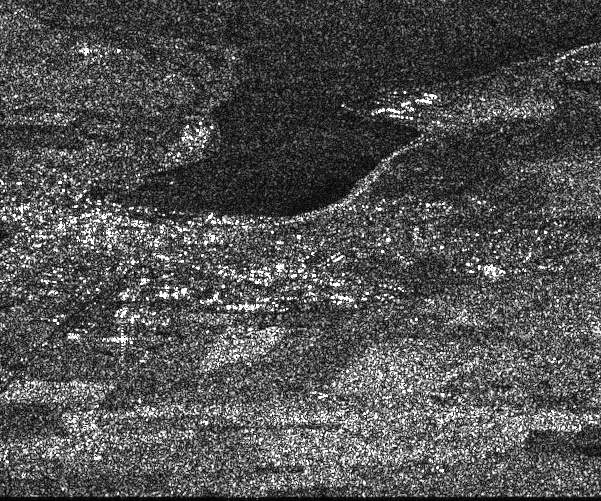

In [8]:
SlcUtil.show_img(master_data)

In [9]:
#interferogram = master_data.* conj.(slave_data) .*flat;

In [14]:
# test complex coherence estimate
kernel = ones(2,8);
number_of_rows = size(master_data)[1] - size(kernel)[1] + 1
number_of_cols = size(master_data)[2] - size(kernel)[2] + 1
#nominator = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
master_abs_sq = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
slave_abs_sq = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
complex_coherence = Array{Complex{Float64}, 2}(undef, number_of_rows, number_of_cols)
count = 0
for i in 1:number_of_rows
    for j in 1:number_of_cols
        i_range = i:i + size(kernel)[1] - 1
        j_range = j:j + size(kernel)[2] - 1
        nominator = sum(kernel .* master_data[i_range, j_range] .* conj.(slave_data[i_range, j_range]) .* flat[i_range, j_range])
        master_abs_sq[i, j] = sum(sqrt.(abs2.(kernel .* master_data[i_range, j_range])))
        slave_abs_sq[i, j] = sum(sqrt.(abs2.(kernel .* slave_data[i_range, j_range])))
        complex_coherence[i, j] = nominator / (master_abs_sq[i, j] * slave_abs_sq[i, j])
    end
end

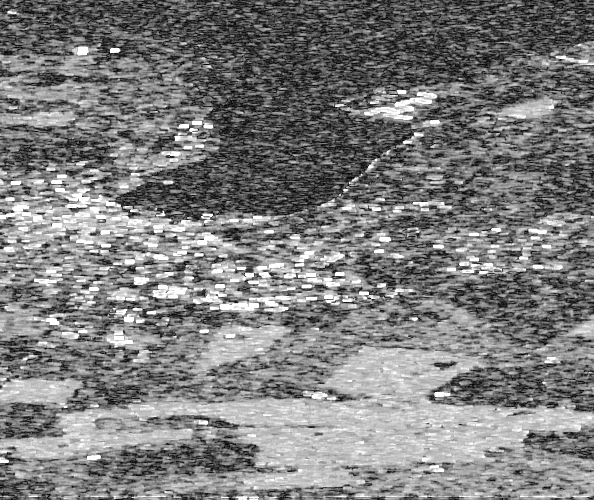

In [15]:
SlcUtil.show_img(complex_coherence)

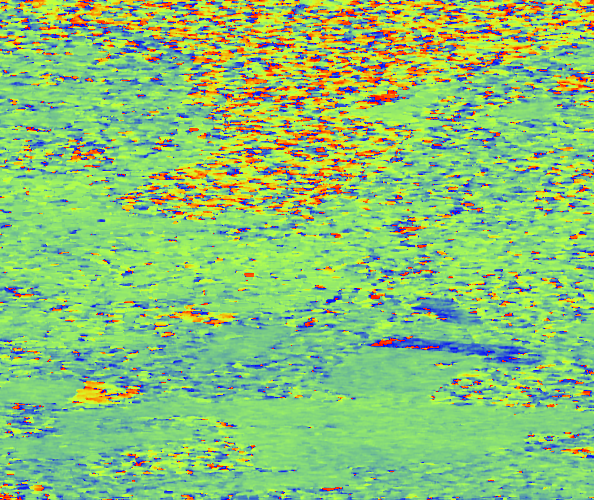

In [16]:
SlcUtil.plot_phase(complex_coherence)

In [17]:
SlcUtil._phase_colorbar()

 -π                 -π/2                 0                 π/2                 π
